In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from timeit import default_timer


In [2]:
movies = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/movie.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['movieId','title','genres'] )
ratings = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/rating.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['userId','movieId','rating','timestamp'])

In [3]:
df_movies = movies 
df_ratings = ratings

# EDA 

In [4]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    

Number of movies Null values:  22
Number of ratings Null values:  0


In [5]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27256 entries, 0 to 27255
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieId             27256 non-null  int64  
 1   title               27256 non-null  object 
 2   year                27256 non-null  float64
 3   (no genres listed)  27256 non-null  bool   
 4   Action              27256 non-null  bool   
 5   Adventure           27256 non-null  bool   
 6   Animation           27256 non-null  bool   
 7   Children            27256 non-null  bool   
 8   Comedy              27256 non-null  bool   
 9   Crime               27256 non-null  bool   
 10  Documentary         27256 non-null  bool   
 11  Drama               27256 non-null  bool   
 12  Fantasy             27256 non-null  bool   
 13  Film-Noir           27256 non-null  bool   
 14  Horror              27256 non-null  bool   
 15  IMAX                27256 non-null  bool   
 16  Musi

# Average ratings per user. 

c:\users\vaibhav gala\python\lib\site-packages\pandas\plotting\_matplotlib\hist.py:59: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)
c:\users\vaibhav gala\python\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


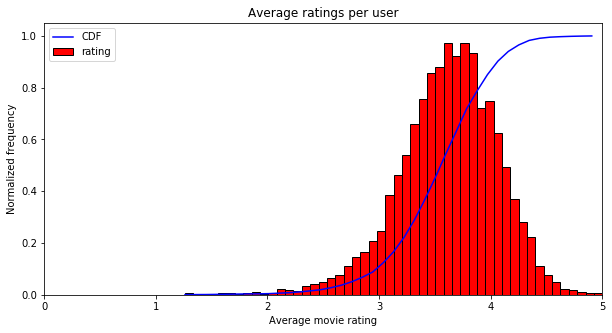

Elapsed time(sec):  1.22


In [6]:

st = default_timer()

dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, normed=True, color = 'red',edgecolor='black', figsize=(10,5))
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, normed=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

# Ratings per movie.

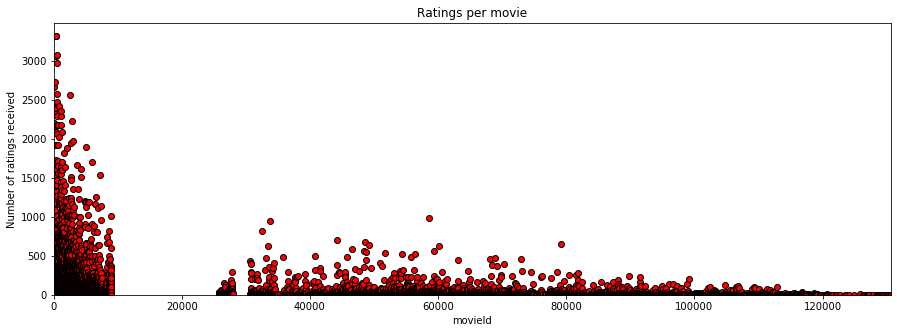

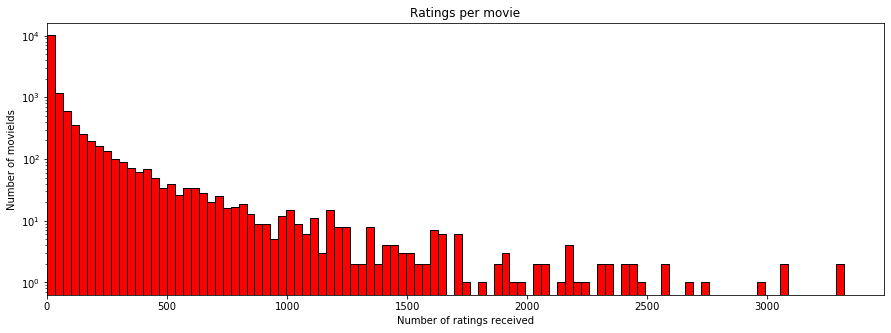

In [7]:

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black', color = 'red')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', color = 'red', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()


# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean()

# Housekeeping
%reset_selective -f (^dftmp$|^tmp$)


# Average rating for all individual movies. 

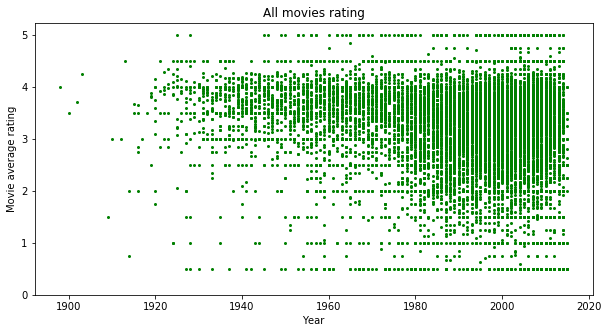

Elapsed time(sec):  0.6


In [8]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [9]:
# Reinitialising variables
movies = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/movie.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['movieId','title','genres'] )
ratings = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/rating.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['userId','movieId','rating','timestamp'])
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())
#additional temporary variable
df_movies1 = movies 
df_ratings1 = ratings

## Word cloud visulaisation for movie title

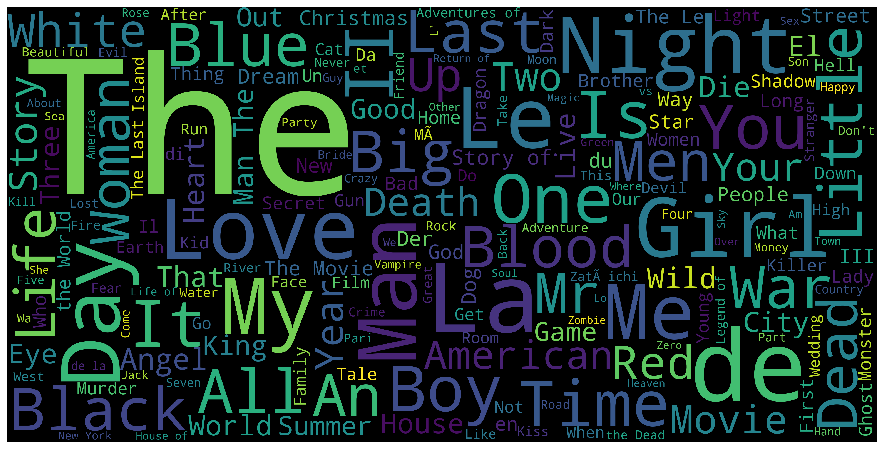

In [10]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
df_movies1['title'] = df_movies1['title'].fillna("").astype('str')
title_corpus = ' '.join(df_movies1['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

## Most popular genres of movie released

<BarContainer object of 19 artists>

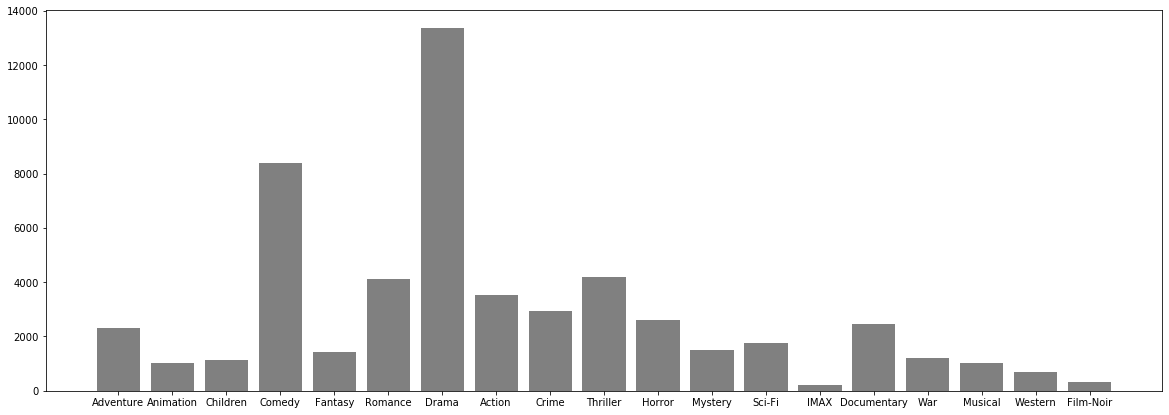

In [11]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(), color = 'grey')

## wordcloud for genres

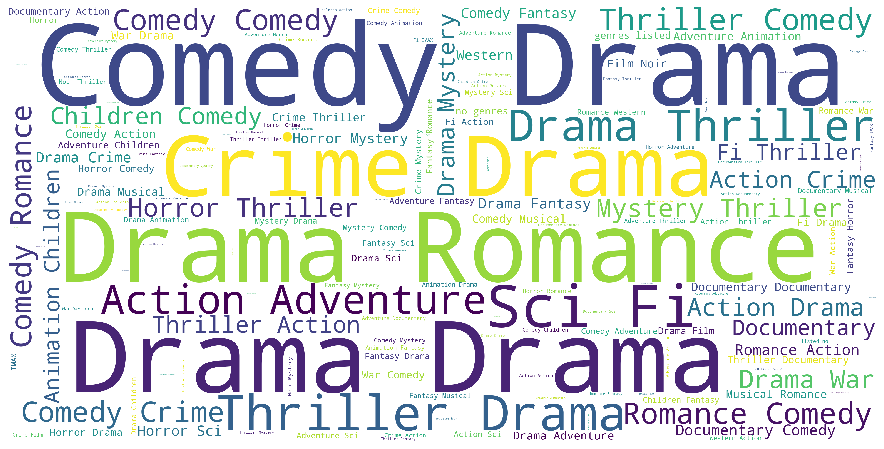

In [12]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
df_movies1['genres'] = df_movies1['genres'].fillna("").astype('str')
title_corpus = ' '.join(df_movies1['genres'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

## distribution of users rating

In [13]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [14]:
# Get summary statistics of rating
ratings['rating'].describe()

count    1000000.000000
mean           3.526803
std            1.052167
min            0.500000
25%            3.000000
50%            4.000000
75%            4.000000
max            5.000000
Name: rating, dtype: float64

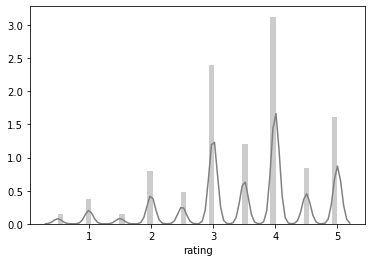

In [15]:
sns.distplot(df_ratings["rating"], color = 'grey')

In [16]:
#Grouping the rating based on user
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])
ratings_grouped_by_users.head(10)

movieId                year              rating           timestamp  \
          size         mean   size         mean   size      mean      size   
userId                                                                       
1          175  3428.537143  175.0  1985.902857  175.0  3.742857       175   
2           61  2098.524590   61.0  1985.245902   61.0  4.000000        61   
3          187  1698.331551  187.0  1984.256684  187.0  4.122995       187   
4           28   394.964286   28.0  1989.750000   28.0  3.571429        28   
5           66   574.484848   66.0  1990.227273   66.0  4.272727        66   
6           24   461.875000   24.0  1993.916667   24.0  3.750000        24   
7          276  2425.079710  276.0  1986.833333  276.0  3.289855       276   
8           70   339.385714   70.0  1993.642857   70.0  3.800000        70   
9           35  3185.742857   35.0  1994.400000   35.0  3.057143        35   
10          38  1470.973684   38.0  1979.578947   38.0  3.894737        38   

                     
               mean  
userId               
1       2004.737143  
2       2000.000000  
3       1999.000000  
4       1996.000000  
5       1996.000000  
6       1997.000000  
7       2002.000000  
8       1996.000000  
9       2001.000000  
10      1999.000000

## Top 10 users who have rated most of the movies

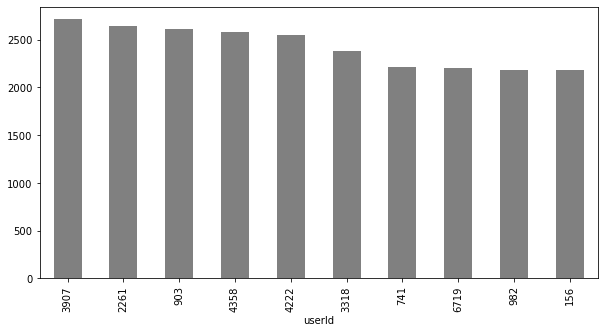

In [17]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind = 'bar', figsize = (10,5), color = 'grey')

In [18]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)

In [19]:
ratings_grouped_by_movies.shape

(13950, 4)

In [20]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

# movies with average rating

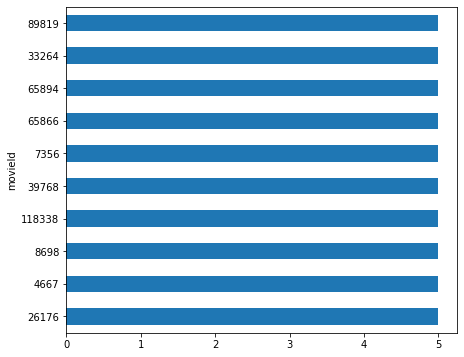

In [21]:

ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

# Movies with low average rating

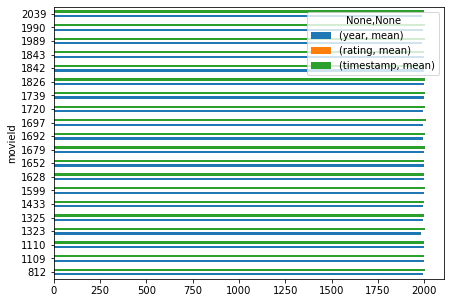

In [22]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]
low_rated_movies.head(20).plot(kind='barh', figsize=(7,5))

# Content based filtering

In [33]:
movies = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/movie.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['movieId','title','genres'] )
ratings = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/rating.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['userId','movieId','rating','timestamp'])
df_movies = movies 
df_ratings = ratings

In [25]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
# print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
# print(tfidf_movies_genres_matrix.shape)
# print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
# print(cosine_sim_movies)

In [26]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    #df_movies['title'] = df_movies['title'].fillna("").astype('str')
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:3]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return df_movies['title'].iloc[movie_indices]

In [34]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                        Four Rooms (1995)
18    Ace Ventura: When Nature Calls (1995)
Name: title, dtype: object

In [35]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)


In [30]:
get_recommendation_content_model(150)

{'Ace Ventura: When Nature Calls',
 'Addams Family Values',
 'American Astronaut, The',
 "Antonia's Line (Antonia)",
 'Aristocats, The',
 'Backbeat',
 'Bambi',
 'Band Wagon, The',
 'Bedknobs and Broomsticks',
 'Beowulf & Grendel',
 'Big Bully',
 'Black Beauty',
 'Carpool',
 'Dangerous Minds',
 'Deliverance',
 'Earth Girls Are Easy',
 'Excalibur',
 'Flintstones, The',
 'Four Rooms',
 'Gay Divorcee, The',
 'Muppet Movie, The',
 'Othello',
 "Pete's Dragon",
 'Program, The',
 'Ratatouille',
 'Romper Stomper',
 'Seeker: The Dark Is Rising, The',
 'Something to Sing About',
 'Song of the South',
 'Striptease',
 'Super Troopers',
 'Swan Princess, The',
 'Top Hat',
 'Trixie',
 "What's Love Got to Do with It?",
 'Whom the Gods Wish to Destroy (Nibelungen, Teil 1: Siegfried, Die)'}

# Model evaluation with KNN
Here the model is evaluated on based of if there is exact match of genres with the genres of movie which is already watch by user

In [36]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=15) #inceease size of n_neighbors for reducing processing time
    x= tfidf_movies_genres_matrix
    y = df_movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

Evaluation in the code takes more than 30 mins to run as there are 1 million rows so run the snippet below and go for a stroll else increase the size of n_neighbors above to '100' for reducing processing time

In [37]:
# Evaluation takes 
true_count = 0
false_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in df_movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.9249211819048317
Fault:0.07507881809516827


In [38]:
# reinitialising variables for different model
movies = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/movie.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['movieId','title','genres'] )
ratings = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/rating.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['userId','movieId','rating','timestamp'])
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())
df_movies = movies 
df_ratings = ratings

# Collaborative Filtering

## Item-Item Filtering

In [39]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [40]:
df_movies_ratings=pd.merge(df_movies, df_ratings)

In [41]:
df_movies_ratings

,movieId,title,genres,year,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,3,4.0,1999-12-11 13:36:47
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,6,5.0,1997-03-13 17:50:52
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,8,4.0,1996-06-05 13:37:51
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,10,4.0,1999-11-25 02:44:47
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,11,4.5,2009-01-02 01:13:41
...,...,...,...,...,...,...,...
999995,130219,The Dark Knight,Action|Crime|Drama|Thriller,2011,1339,4.5,2015-03-20 11:49:16
999996,130462,The Boy,(no genres listed),2015,5731,4.0,2015-03-24 17:20:50
999997,130490,Insurgent,Action|Romance|Sci-Fi,2015,2423,1.0,2015-03-20 21:43:39
999998,130490,Insurgent,Action|Romance|Sci-Fi,2015,3397,3.5,2015-03-27 21:28:59


Here Pivot table function is used as we want one to one maping between movies, user and their rating. So by default pivot_table command takes average if we have multiple values of one combination.

In [42]:
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(13950, 6743)

In [43]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,6734,6735,6736,6737,6738,6739,6740,6741,6742,6743
0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.5,4.0,4.0,3.0,0.0,4.0,0.0,4.0,0.0,4.0
1,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#creating similarity matrix 
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.to_numpy(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,13940,13941,13942,13943,13944,13945,13946,13947,13948,13949
0,0.000000,0.413458,0.316981,0.140497,0.308255,0.401422,0.309585,0.090959,0.169579,0.389665,...,0.022507,0.020006,0.025497,0.0,0.020006,0.015005,0.015005,0.022507,0.023702,0.020006
1,0.413458,0.000000,0.248508,0.153204,0.283599,0.280085,0.245782,0.189284,0.143791,0.406851,...,0.035312,0.035312,0.000000,0.0,0.013242,0.026484,0.026484,0.000000,0.016977,0.013242
2,0.316981,0.248508,0.000000,0.159079,0.455963,0.292310,0.389057,0.136521,0.260051,0.220988,...,0.000000,0.000000,0.026766,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.140497,0.153204,0.159079,0.000000,0.169485,0.124513,0.193043,0.156757,0.152897,0.127811,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.308255,0.283599,0.455963,0.169485,0.000000,0.250563,0.402254,0.164079,0.227696,0.220861,...,0.000000,0.000000,0.018360,0.0,0.000000,0.030227,0.000000,0.000000,0.023251,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13945,0.015005,0.026484,0.000000,0.000000,0.030227,0.000000,0.027419,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13946,0.015005,0.026484,0.000000,0.000000,0.000000,0.029469,0.000000,0.000000,0.000000,0.025736,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13947,0.022507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13948,0.023702,0.016977,0.000000,0.000000,0.023251,0.000000,0.021091,0.016050,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Below function will take the movie name as a input and will find the movies which are similar to this movie. This function first find the index of movie in movies frame and then take the similarity of movie and align in movies dataframe so that we can get the similarity of the movie with all other movies.

In [45]:
def item_similarity(movieName): 
    """
    recomendates similar movies
   :param data: name of the movie 
   """
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]

        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movieId', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [46]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ['similarity'], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movieId']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= df_ratings[df_ratings['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [47]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movieId']==id]['title'])
    return movie_titles

In [48]:
user_id = 150
recommend_movies= movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Sorry, the movie is not in the database!
Movies you should watch are:

[11974    Harry Potter and the Order of the Phoenix
Name: title, dtype: object, 12032    Superbad
Name: title, dtype: object, 12032    Superbad
Name: title, dtype: object, 13059    Flash of Genius
Name: title, dtype: object, 12032    Superbad
Name: title, dtype: object, 12032    Superbad
Name: title, dtype: object, 12032    Superbad
Name: title, dtype: object, 12032    Superbad
Name: title, dtype: object, 12032    Superbad
Name: title, dtype: object]


## Recomendation using voice recognition

In [49]:
#Converting the text to speech using google text to speech api
import random
def text_to_speech():
    file = open('dd.txt','w')
    file.writelines(f'hello User \n')
    file.writelines('The Movie You Should Watched Next are \n') 
    for res in result:
        res = ''.join(res)
        file.write(res+'\n')
    file.close()
    file = open('dd.txt','r')
    data= file.read()
    print(data)
    file.close()
    
    
    # Language in which you want to convert 
    language = 'en'
      
    # Passing the text and language to the engine,  
    # here we have marked slow=False. Which tells  
    # the module that the converted audio should  
    # have a high speed 
    myobj = gtts.gTTS(text=data, lang=language, slow=False) 
      
    # Saving the converted audio in a mp3 file named   
    i=random.randint(1,100)
    file='new'+str(i)+'.mp3'
    myobj.save(file) 
      
    #Playing the converted file 
    playsound(file)

In [50]:
#Making the method to get text from speech
import speech_recognition as sr

In [51]:
def speech_to_text():

    sample_rate = 48000

    chunk_size = 2048
    #Initialize the recognizer 
    r = sr.Recognizer() 

    with sr.Microphone(sample_rate = sample_rate,  
                            chunk_size = chunk_size) as source: 
        #wait for a second to let the recognizer adjust the  
        #energy threshold based on the surrounding noise level 
        r.adjust_for_ambient_noise(source) 
        print ("Speak the name of the movie ")
        #listens for the user's input 
        audio = r.listen(source) 

        try: 
            text = r.recognize_google(audio) 
            print(text)

        #error occurs when google could not understand what was said 

        except sr.UnknownValueError: 
            print("Google Speech Recognition could not understand audio") 

        except sr.RequestError as e: 
            print("Could not request results from Google  Speech Recognition service; {0}".format(e)) 
                
        return text

In [186]:
#install this libraries from cmd for voice recognition
#pip install playsound
#pip install pipwin
#pip install PyAudio
#pip install SpeechRecognition
#pip install gtts

Note: you may need to restart the kernel to use updated packages.


'c:\users\vaibhav' is not recognized as an internal or external command,
operable program or batch file.


In [52]:
#Getting the output 
#after the output display pops "speak the name of the movie"  speak a name of the movie and after few seconds it will speak suggestion to you
#result are also stored in a text file in your local file system 

from playsound import playsound
import re 
import gtts
text=speech_to_text()
result=get_recommendations_based_on_genres(text)
text_to_speech()

Speak the name of the movie 
Batman
hello User 
The Movie You Should Watched Next are 
Assassins
Die Hard: With a Vengeance



# Model-Based Collaborative Filtering

## Matrix factorisation for performing data decomposition technique

In [53]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/rating.csv',nrows = 1000000)

# Reading movies file
movies = pd.read_csv('F:/Semester 2/Machine Learning/Assignment 2/movielens-20m-dataset/movie.csv',nrows = 1000000)
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [57]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6743 | Number of movies = 13950


Now we want the format of our ratings matrix to be one row per user and one column per movie. To do so, we willl pivot ratings to get that and call the new variable Ratings (with a capital *R).

In [58]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,129350,129354,129428,129707,130052,130073,130219,130462,130490,130642
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Last but not least, we need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [59]:
R = Ratings.to_numpy()
#print(R)
user_ratings_mean = np.mean(R, axis = 1)
#print(user_ratings_mean.shape)
print(user_ratings_mean.size)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) ## Making the user_ratings_mean vertical by reshaping

6743


In [60]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens dataset is 98.9%



## Setting Up SVD

Scipy and Numpy both have functions to do the singular value decomposition. We are going to use the Scipy function svds because it let us choose how many latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [61]:
from scipy.sparse.linalg import svds

In [62]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)
print('Size of sigma: ' , sigma.size)

Size of sigma:  50


converting summation to diagonal matrix 

In [63]:
sigma = np.diag(sigma)

In [64]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 142.61249165    0.            0.         ...    0.
     0.            0.        ]
 [   0.          143.85301215    0.         ...    0.
     0.            0.        ]
 [   0.            0.          144.52622401 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  614.79347143
     0.            0.        ]
 [   0.            0.            0.         ...    0.
   656.79707909    0.        ]
 [   0.            0.            0.         ...    0.
     0.         1560.07209886]]


In [65]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (6743, 50)
Shape of Vt:  (50, 13950)


##  Making Predictions from the Decomposed Matrices

In [66]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [67]:
print('All user predicted rating : ', all_user_predicted_ratings.shape)

All user predicted rating :  (6743, 13950)


In [68]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,129350,129354,129428,129707,130052,130073,130219,130462,130490,130642
0,0.462816,0.886560,0.116673,0.008308,-0.215565,0.110520,-0.358674,-0.024280,-0.217334,0.032192,...,0.007858,-0.009063,-0.000590,-0.002358,-0.003434,0.002593,-0.008268,-0.010008,0.003211,-0.005214
1,0.979778,0.101947,0.331502,0.084563,0.198166,0.225804,0.464224,-0.000231,0.089829,-0.063064,...,-0.002574,-0.007137,-0.005901,-0.000340,-0.000661,0.005147,-0.003343,0.003982,0.007401,-0.000236
2,2.042083,0.828816,-0.159202,-0.011740,-0.123303,0.469264,0.055829,0.002462,-0.053686,0.352812,...,0.003774,0.014084,0.007017,0.004093,0.003028,0.027928,-0.001567,0.006333,0.009272,0.001203
3,-0.527892,0.673756,0.420112,0.001046,0.276751,0.840723,0.090925,0.090294,0.186957,0.946194,...,0.001692,0.001809,0.001136,0.002849,0.001862,0.000747,0.002181,0.002332,0.004352,0.000067
4,2.246131,1.121891,1.234257,0.115929,1.183925,0.619121,1.367333,0.157426,0.296183,1.433395,...,-0.000493,0.009807,-0.009911,0.001258,0.001165,0.002508,0.000942,0.001017,0.007514,0.002189


In [69]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    """
    Implementation of SVD by hand
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [70]:
already_rated, predictions = recommend_movies(preds, 150, movies, ratings, 20)

User 150 has already rated 26 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [71]:
# Top 20 movies that User 150 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres,year
25,150,66934,5.0,2010-12-30 12:53:31,Dr. Horrible's Sing-Along Blog,Comedy|Drama|Musical|Sci-Fi,2008
24,150,7153,4.0,2010-12-30 12:52:29,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy,2003
23,150,5952,4.0,2010-12-30 12:52:31,"Lord of the Rings: The Two Towers, The",Adventure|Fantasy,2002
22,150,4993,4.0,2010-12-30 12:52:26,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,2001
6,150,1033,4.0,2010-12-30 12:50:06,"Fox and the Hound, The",Animation|Children|Drama,1981
7,150,1298,4.0,2010-12-30 12:48:43,Pink Floyd: The Wall,Drama|Musical,1982
9,150,1586,4.0,2010-12-30 12:48:20,G.I. Jane,Action|Drama,1997
20,150,2926,4.0,2010-12-30 12:50:46,Hairspray,Comedy|Drama,1988
12,150,2114,4.0,2010-12-30 12:50:50,"Outsiders, The",Drama,1983
18,150,2502,4.0,2010-12-30 12:55:01,Office Space,Comedy|Crime,1999


In [72]:
# Top 20 movies that User 20 hopefully will enjoy
predictions

,movieId,title,genres,year
2467,2571,"Matrix, The",Action|Sci-Fi|Thriller,1999
2852,2959,Fight Club,Action|Crime|Drama|Thriller,1999
1165,1197,"Princess Bride, The",Action|Adventure|Comedy|Fantasy|Romance,1987
6405,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,2003
2657,2762,"Sixth Sense, The",Drama|Horror|Mystery,1999
12500,58559,"Dark Knight, The",Action|Crime|Drama|IMAX,2008
107,110,Braveheart,Action|Drama|War,1995
1106,1136,Monty Python and the Holy Grail,Adventure|Comedy|Fantasy,1975
3466,3578,Gladiator,Action|Adventure|Drama,2000
4190,4306,Shrek,Adventure|Animation|Children|Comedy|Fantasy|Ro...,2001


## SVD model evaluation

In [73]:
#if you havent installed visual studio then please follow the instructions in the following link
# https://medium.com/@jacky_ttt/day060-fix-error-microsoft-visual-c-14-0-is-required-629413e798cd 
# Import libraries from Surprise package

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId','movieId', 'rating']], reader)


In [74]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
cross_validate(svd, data, measures=['RMSE'], cv = 5, verbose = True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8366  0.8347  0.8320  0.8340  0.8357  0.8346  0.0016  
Fit time          62.43   64.17   60.81   60.78   60.79   61.80   1.35    
Test time         2.34    2.41    2.27    2.22    2.26    2.30    0.07    


{'test_rmse': array([0.83664993, 0.83471106, 0.83199412, 0.83397053, 0.83569819]),
 'fit_time': (62.431782722473145,
  64.172367811203,
  60.81040096282959,
  60.7794451713562,
  60.79141306877136),
 'test_time': (2.3427324295043945,
  2.411515951156616,
  2.2678959369659424,
  2.2210586071014404,
  2.2629473209381104)}

We get a mean Root Mean Square Error of 0.834 which is pretty good. Let's now train on the dataset and arrive at predictions.

In [75]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [76]:
#We will pick again user with ID 150 and check the ratings he has given.
ratings[ratings['userId'] == 150]

,userId,movieId,rating,timestamp
19209,150,107,3.0,2010-12-30 12:48:17
19210,150,223,2.5,2010-12-30 12:55:16
19211,150,455,1.5,2010-12-30 12:47:41
19212,150,719,1.5,2010-12-30 12:47:44
19213,150,1015,3.5,2010-12-30 12:50:32
19214,150,1030,3.0,2010-12-30 12:50:55
19215,150,1033,4.0,2010-12-30 12:50:06
19216,150,1298,4.0,2010-12-30 12:48:43
19217,150,1381,1.5,2010-12-30 12:50:09
19218,150,1586,4.0,2010-12-30 12:48:20


Now let's use SVD to predict the rating that User with ID 150 will give to a random movie (let's say with Movie ID 1994).

In [77]:
svd.predict(150, 1994)

Prediction(uid=150, iid=1994, r_ui=None, est=2.9535518929417472, details={'was_impossible': False})

For movie with ID 1994, user 150 get an estimated prediction with a sxore of 2.9535 The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

In [78]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import SVDpp
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

# Evaluating Collaborative Filtering on predictions made by SVD

Hit Ratio It is ratio of number of hits/ Total recommendation

In [79]:
user_id=150
def evaluation_collaborative_svd_model(userId,userOrItem):
    """
    hydrid the functionality of Collaborative based and svd based model to see if ratings of predicted movies 
    :param userId: userId of user, userOrItem is a boolean value if True it is User-User and if false Item-Item
    :return: dataframe of movies and ratings
    """ 
    movieIdsList= list()
    movieRatingList=list()
    movieIdRating= pd.DataFrame(columns=['movieId','rating'])
    movieIdsList=recommendedMoviesAsperItemSimilarity(user_id)
    for movieId in movieIdsList:
        predict = svd.predict(userId, movieId)
        movieRatingList.append([movieId,predict.est])
        movieIdRating = pd.DataFrame(np.array(movieRatingList), columns=['movieId','rating'])
        count=movieIdRating[(movieIdRating['rating'])>=3]['movieId'].count()
        total=movieIdRating.shape[0]
        hit_ratio= count/total
    return hit_ratio

In [80]:
print("Hit ratio of Item-Item collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,True))

Hit ratio of Item-Item collaborative filtering
Sorry, the movie is not in the database!
1.0


# Hybrid model

After developing individual models as discussed earlier, we now stack them in order to get better results.

Content Based Filtering + SVD

Steps:

   1. Run Content based filtering and determine the movies which we want to recommend to the user.
   2. Filter and sort the recommendations of CF using SVD predicted ratings.


In [81]:
user_id=150
df_movies=movies
def hybrid_content_svd_model(userId):
    """
    hydrid the functionality of content based and svd based model to recommend user top 10 movies. 
    :param userId: userId of user
    :return: list of movies recommended with rating given by svd model
    """
    recommended_movies_by_content_model = get_recommendation_content_model(userId)
    recommended_movies_by_content_model = df_movies[df_movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    for key, columns in recommended_movies_by_content_model.iterrows():
        predict = svd.predict(userId, columns["movieId"])
        recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
#         if(predict.est < 2):
#             recommended_movies_by_content_model = recommended_movies_by_content_model.drop([key])
    return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:10]
        
hybrid_content_svd_model(user_id)

c:\users\vaibhav gala\python\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\vaibhav gala\python\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,movieId,title,genres,year,svd_rating
928,945,Top Hat,Comedy|Musical|Romance,1935,3.836263
81,82,Antonia's Line (Antonia),Comedy|Drama,1995,3.780226
890,907,"Gay Divorcee, The",Comedy|Musical|Romance,1934,3.780061
11614,50872,Ratatouille,Animation|Children|Drama,2007,3.558756
518,522,Romper Stomper,Action|Drama,1992,3.529586
473,477,What's Love Got to Do with It?,Drama|Musical,1993,3.484648
918,935,"Band Wagon, The",Comedy|Musical,1953,3.453473
2785,2871,Deliverance,Adventure|Drama|Thriller,1972,3.441882
15400,78490,Othello,Drama|Romance,1965,3.436299
5014,5110,Super Troopers,Comedy|Crime|Mystery,2001,3.391212
